In [1]:
!pip install pgmpy --upgrade

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import BayesianEstimator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 633.5 kB/s eta 0:00:001m625.9 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 1.3 MB/s eta 0:00:001.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pgmpy]━━━━━ 3/4 [pgmpy]pl]


In [14]:
# -----------------------
# Part 1: Model Construction
# -----------------------
print("--- Part 1: Model Construction ---\n")

# Define network structure (edges)
edges = [
    ('C', 'W'),  # CGPA -> Written Test
    ('T', 'W'),  # Technical Skills -> Written Test
    ('T', 'I'),  # Technical Skills -> Interview
    ('S', 'I'),  # Soft Skills -> Interview
    ('W', 'J'),  # Written Test -> Job Offer
    ('I', 'J')   # Interview -> Job Offer
]

placement_model = DiscreteBayesianNetwork(edges)

# --- Root Node CPDs ---
cpd_c = TabularCPD(
    variable='C', variable_card=3,
    values=[[0.2], [0.5], [0.3]],
    state_names={'C': ['Low', 'Medium', 'High']}
)

cpd_t = TabularCPD(
    variable='T', variable_card=2,
    values=[[0.4], [0.6]],
    state_names={'T': ['Weak', 'Strong']}
)

cpd_s = TabularCPD(
    variable='S', variable_card=2,
    values=[[0.5], [0.5]],
    state_names={'S': ['Weak', 'Strong']}
)

# --- Conditional CPDs ---
# P(W | C, T)
# Note column ordering: evidence=['C','T'] with evidence_card=[3,2]
cpd_w = TabularCPD(
    variable='W', variable_card=2,
    values=[
        [0.8, 0.6, 0.3, 0.4, 0.2, 0.1],  # W=Fail
        [0.2, 0.4, 0.7, 0.6, 0.8, 0.9]   # W=Pass
    ],
    evidence=['C', 'T'],
    evidence_card=[3, 2],
    state_names={
        'W': ['Fail', 'Pass'],
        'C': ['Low', 'Medium', 'High'],
        'T': ['Weak', 'Strong']
    }
)

# P(I | T, S)
# evidence=['T','S'] with evidence_card=[2,2]
cpd_i = TabularCPD(
    variable='I', variable_card=2,
    values=[
        [0.7, 0.4, 0.3, 0.1],  # I=Fail
        [0.3, 0.6, 0.7, 0.9]   # I=Pass
    ],
    evidence=['T', 'S'],
    evidence_card=[2, 2],
    state_names={
        'I': ['Fail', 'Pass'],
        'T': ['Weak', 'Strong'],
        'S': ['Weak', 'Strong']
    }
)

# P(J | W, I)
# evidence=['W','I'] with evidence_card=[2,2]
cpd_j = TabularCPD(
    variable='J', variable_card=2,
    values=[
        [0.99, 0.8, 0.6, 0.1],  # J=No
        [0.01, 0.2, 0.4, 0.9]   # J=Yes
    ],
    evidence=['W', 'I'],
    evidence_card=[2, 2],
    state_names={
        'J': ['No', 'Yes'],
        'W': ['Fail', 'Pass'],
        'I': ['Fail', 'Pass']
    }
)

# Add CPDs to the model
placement_model.add_cpds(cpd_c, cpd_t, cpd_s, cpd_w, cpd_i, cpd_j)

# Validate model
is_valid = placement_model.check_model()
print("Model valid?:", is_valid)

--- Part 1: Model Construction ---

Model valid?: True



--- Visualizing the Bayesian Network (DAG) ---



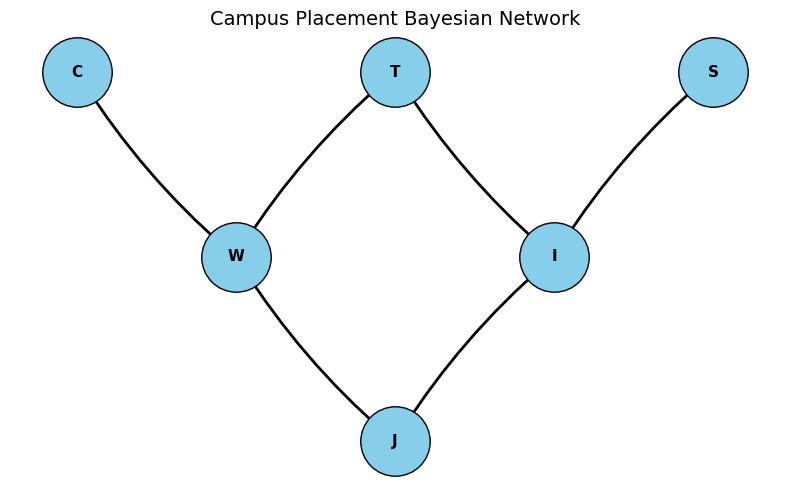

In [15]:
# -----------------------
# Task 1.1: Visualize the Network
# -----------------------
print("\n--- Visualizing the Bayesian Network (DAG) ---\n")

graph = nx.DiGraph()
graph.add_edges_from(placement_model.edges())

# Layout: place root nodes at top, intermediates middle, target bottom
pos = {
    'C': (-1, 2), 'T': (0, 2), 'S': (1, 2),
    'W': (-0.5, 1), 'I': (0.5, 1),
    'J': (0, 0)
}

plt.figure(figsize=(8, 5))
nx.draw_networkx_nodes(graph, pos, node_color='skyblue', node_size=2500, edgecolors='black')
nx.draw_networkx_labels(graph, pos, font_size=11, font_weight='bold')
nx.draw_networkx_edges(
    graph, pos,
    arrows=True, arrowstyle='-|>', arrowsize=18, width=2,
    connectionstyle='arc3,rad=0.08'
)
plt.title("Campus Placement Bayesian Network", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
# -----------------------
# Part 2: Inference & Analysis
# -----------------------
print("\n--- Part 2: Inference & Analysis ---\n")

infer = VariableElimination(placement_model)

# Query helper to print nicely (expects a DiscreteFactor)
def print_query_result(query_factor, var_name):
    # query_factor is a DiscreteFactor; its .values attribute holds probabilities in correct order
    probs = np.array(query_factor.values, dtype=float)
    # Get state names from the CPD of the variable in the model
    state_names = placement_model.get_cpds(var_name).state_names[var_name]
    for s, p in zip(state_names, probs):
        print(f"  P({var_name}={s}) = {p:.6f}")

# Helper to get a single state's probability from a factor
def prob_of_state(query_factor, var_name, state_label):
    probs = np.array(query_factor.values, dtype=float)
    state_names = placement_model.get_cpds(var_name).state_names[var_name]
    idx = state_names.index(state_label)
    return probs[idx]

# 1) Baseline P(J)
print("1) Baseline: P(J)")
q1 = infer.query(variables=['J'])
print(q1)                # prints DiscreteFactor
print_query_result(q1, 'J')

# 2) Predictive: P(J | C='High', T='Strong')
print("\n2) Predictive: P(J | C='High', T='Strong')")
q2 = infer.query(variables=['J'], evidence={'C': 'High', 'T': 'Strong'})
print(q2)
print_query_result(q2, 'J')

# 3) Diagnostic: P(T | J='Yes')
print("\n3) Diagnostic: P(T | J='Yes')")
q3 = infer.query(variables=['T'], evidence={'J': 'Yes'})
print(q3)
print_query_result(q3, 'T')

# 4) Explaining Away analysis
print("\n4) Explaining Away Analysis:")

# P(W | J='Yes')
q4a = infer.query(variables=['W'], evidence={'J': 'Yes'})
print("\n  P(W | J='Yes'):")
print(q4a)
print_query_result(q4a, 'W')
p_w_pass_given_j = prob_of_state(q4a, 'W', 'Pass')

# P(W | J='Yes', I='Pass')
q4b = infer.query(variables=['W'], evidence={'J': 'Yes', 'I': 'Pass'})
print("\n  P(W | J='Yes', I='Pass'):")
print(q4b)
print_query_result(q4b, 'W')
p_w_pass_given_j_i = prob_of_state(q4b, 'W', 'Pass')


--- Part 2: Inference & Analysis ---

1) Baseline: P(J)
+--------+----------+
| J      |   phi(J) |
+========+==========+
| J(No)  |   0.4823 |
+--------+----------+
| J(Yes) |   0.5177 |
+--------+----------+
  P(J=No) = 0.482346
  P(J=Yes) = 0.517654

2) Predictive: P(J | C='High', T='Strong')
+--------+----------+
| J      |   phi(J) |
+========+==========+
| J(No)  |   0.2638 |
+--------+----------+
| J(Yes) |   0.7362 |
+--------+----------+
  P(J=No) = 0.263800
  P(J=Yes) = 0.736200

3) Diagnostic: P(T | J='Yes')
+-----------+----------+
| T         |   phi(T) |
+===========+==========+
| T(Weak)   |   0.3316 |
+-----------+----------+
| T(Strong) |   0.6684 |
+-----------+----------+
  P(T=Weak) = 0.331561
  P(T=Strong) = 0.668439

4) Explaining Away Analysis:

  P(W | J='Yes'):
+---------+----------+
| W       |   phi(W) |
+=========+==========+
| W(Fail) |   0.0930 |
+---------+----------+
| W(Pass) |   0.9070 |
+---------+----------+
  P(W=Fail) = 0.093024
  P(W=Pass) = 0.90

In [17]:
print("\n  Summary (numeric):")
print(f"    P(W='Pass' | J='Yes')           = {p_w_pass_given_j:.6f}")
print(f"    P(W='Pass' | J='Yes', I='Pass') = {p_w_pass_given_j_i:.6f}")

print("""
  Interpretation:
  W and I are two (independent) causes of J (W -> J <- I). Observing J='Yes' increases
  the probability of both causes (they become more likely). But once we additionally observe
  that one cause (I='Pass') is true, that observation explains the effect (J='Yes'),
  reducing the need to attribute it to the other cause (W='Pass') — hence P(W='Pass')
  typically drops when you add I='Pass'. This is the classic "explaining away" effect.
""")


  Summary (numeric):
    P(W='Pass' | J='Yes')           = 0.906976
    P(W='Pass' | J='Yes', I='Pass') = 0.890828

  Interpretation:
  W and I are two (independent) causes of J (W -> J <- I). Observing J='Yes' increases
  the probability of both causes (they become more likely). But once we additionally observe
  that one cause (I='Pass') is true, that observation explains the effect (J='Yes'),
  reducing the need to attribute it to the other cause (W='Pass') — hence P(W='Pass')
  typically drops when you add I='Pass'. This is the classic "explaining away" effect.



In [18]:
# -----------------------
# Part 5: Parameter Learning (Generate samples -> learn -> compare P(J|W,I))
# -----------------------
print("\n--- Part 5: Parameter Learning ---\n")

# 1) Generate 20,000 samples (seeded for reproducibility)
sampler = BayesianModelSampling(placement_model)
data = sampler.forward_sample(size=20000, seed=42)
print("Generated data shape:", data.shape)
print("First 5 rows of generated data:")
print(data.head())

# 2) New model with same structure (no CPDs)
model_to_learn = DiscreteBayesianNetwork(edges)

# 3) Fit parameters from generated data using BayesianEstimator
model_to_learn.fit(data, estimator=BayesianEstimator, prior_type='BDeu')

# 4) Compare original vs learned CPD for J
print("\nOriginal CPD for P(J | W, I):")
print(cpd_j)

learned_cpd_j = model_to_learn.get_cpds('J')
print("\nLearned CPD for P(J | W, I) from sampled data:")
print(learned_cpd_j)

# Numeric side-by-side
print("\nNumeric comparison (columns correspond to evidence columns in order):")
print("\nOriginal (J=No row):", np.array(cpd_j.values[0]))
print("Learned  (J=No row):", np.array(learned_cpd_j.values[0]))
print("\nOriginal (J=Yes row):", np.array(cpd_j.values[1]))
print("Learned  (J=Yes row):", np.array(learned_cpd_j.values[1]))

print("\nAnalysis: The learned CPD should be close to the original CPD (differences due to sampling noise).")


--- Part 5: Parameter Learning ---



  0%|          | 0/6 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'C': 'C', 'W': 'C', 'T': 'C', 'I': 'C', 'S': 'C', 'J': 'C'}


Generated data shape: (20000, 6)
First 5 rows of generated data:
        C     W       T     I     S    J
0  Medium  Fail  Strong  Pass  Weak   No
1    High  Pass    Weak  Pass  Weak  Yes
2    High  Pass    Weak  Fail  Weak  Yes
3  Medium  Pass  Strong  Pass  Weak  Yes
4     Low  Pass  Strong  Fail  Weak   No

Original CPD for P(J | W, I):
+--------+---------+---------+---------+---------+
| W      | W(Fail) | W(Fail) | W(Pass) | W(Pass) |
+--------+---------+---------+---------+---------+
| I      | I(Fail) | I(Pass) | I(Fail) | I(Pass) |
+--------+---------+---------+---------+---------+
| J(No)  | 0.99    | 0.8     | 0.6     | 0.1     |
+--------+---------+---------+---------+---------+
| J(Yes) | 0.01    | 0.2     | 0.4     | 0.9     |
+--------+---------+---------+---------+---------+

Learned CPD for P(J | W, I) from sampled data:
+--------+----------------------+-----+---------------------+
| I      | I(Fail)              | ... | I(Pass)             |
+--------+-----------------